In [1]:
import torch

print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)
#device=torch.device('cpu')########

1.3.1
cuda:0


In [2]:
import os

corpus_name = "train_model20000.txt"
position = "./data"
corpus = os.path.join(position, corpus_name)
print(corpus)

./data/train_model20000.txt


In [3]:
def printLines(file, n=10):
    with open(file, "r") as datafile:
        lines = datafile.readlines()
    for i in range(len(lines[:n])):
        print(lines[i].split('\t'),i)

In [4]:
printLines(corpus)

['▁なんと !', '▁なんと !\n'] 0
['▁なんと !', '▁ 意味 : 都 を 移 すこ と 、 都 移 り\n'] 1
['▁わたし 安定の た っく んですよー 気づいたら た っ くん いない し 、 い つき あるし 誰 と交換 したのか', '▁まさかの 増えてる w 羨ましい\n'] 2
['▁まさかの 増えてる w 羨ましい', '▁ 連れ が 誰か 引いて た んですよ 、 きっと それ と交換 したんだ と思うんですけど 誰 だったのか w あ 、 た っ くんは しれっと 買取 に出 しましたー\n'] 3
['▁ おち つけ よ', '▁みんな はげ ろ\n'] 4
['▁みんな はげ ろ', '▁昨日 髪の毛 切った ばっかり だけど このくらい つる っ パ ゲ になって きます !\n'] 5
['▁今は 古 すぎて 廃 盤 のもの が多い ので 、 いい モンスター が出る の だと 高い 値 で 売れ ます w', '▁あ 、 やっぱり そう言う のある ですね w\n'] 6
['▁あ 、 やっぱり そう言う のある ですね w', '▁ あります あります w\n'] 7
['▁やだ お', '▁ 目 元 は 知ってる 、 かあ いい\n'] 8
['▁ 目 元 は 知ってる 、 かあ いい', '▁超 過去 写真\n'] 9


In [5]:
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token


class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = len(self.index2word)  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(
            "keep_words {} / {} = {:.4f}".format(
                len(keep_words),
                len(self.word2index),
                len(keep_words) / len(self.word2index),
            )
        )

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [6]:
import unicodedata
import re

MAX_LENGTH = 15  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427


# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding="utf-8").read().strip().split("\n")
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split("\t")] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs


# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(" ")) < MAX_LENGTH and len(p[1].split(" ")) < MAX_LENGTH


# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name):#, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(corpus, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name)#, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 2187212 sentence pairs
Trimmed to 1503290 sentence pairs
Counting words...
Counted words: 21973

pairs:
['▁なんと !', '▁なんと !']
['▁なんと !', '▁ 意味 : 都 を 移 すこ と 、 都 移 り']
['▁ おち つけ よ', '▁みんな はげ ろ']
['▁みんな はげ ろ', '▁昨日 髪の毛 切った ばっかり だけど このくらい つる っ パ ゲ になって きます !']
['▁あ 、 やっぱり そう言う のある ですね w', '▁ あります あります w']
['▁やだ お', '▁ 目 元 は 知ってる 、 かあ いい']
['▁ 目 元 は 知ってる 、 かあ いい', '▁超 過去 写真']
['▁いつ できますか 。', '▁今 大丈夫です !']
['▁今 大丈夫です !', '▁ カフェ の 内 部 に 来てください']
['▁絶対 上手い って ! 描いて みて', '▁それはない ね ! ミニ ー ちゃん ?']


In [7]:
MIN_COUNT = 10  # Minimum word count threshold for trimming


def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print(
        "Trimmed from {} pairs to {}, {:.4f} of total".format(
            len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)
        )
    )
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)
voc2 = Voc(corpus_name)
for pair in pairs:
    voc2.addSentence(pair[0])
    voc2.addSentence(pair[1])
print("Counted words in voc", voc.num_words)
#vocはコーパスに対して十分な語彙の辞書、コーパスに無い単語も含まれてる。
#(vocを作成後、出現頻度の低い単語を削除し、削除された単語を含む文章をコーパスから削除したため。)
print("Counted words in voc2:", voc2.num_words)   
#voc2はコーパスに対して必要十分な語彙の辞書、コーパス無いの単語全てを含んでいて、辞書内の単語は必ずコーパスに登場する。
#(vocのように削除された単語を含む文章をコーパスから削除した後、その新しいコーパスから作成したのがvoc2だから。)

keep_words 20355 / 21970 = 0.9265
Trimmed from 1503290 pairs to 1499411, 0.9974 of total
Counted words in voc 20358
Counted words in voc2: 20358


In [8]:
import random
import itertools


def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(" ")] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))


####zip_longest(*[[あ,い,う,え,お],[か,き,く,け,こ,さ]])→ (あ,か)(い,き)(う,く)(え,け)(お,こ)(pad,さ)　にしてくれる


def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)  # Byte?
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len


# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

# print("input_variable:", input_variable)
# print("lengths:", lengths)
# print("target_variable:", target_variable)
# print("mask:", mask)
# print("max_target_len:", max_target_len)

In [9]:
import torch.nn as nn


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            dropout=(0 if n_layers == 1 else dropout),
            bidirectional=True,
        )

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)

        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, : self.hidden_size] + outputs[:, :, self.hidden_size :]
        # Return output and final hidden state
        return outputs, hidden

In [10]:
import torch.nn.functional as F


class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        if self.method not in ["dot", "general", "concat"]:
            raise ValueError(self.method, "is not an appropriate attention method.")

        elif self.method == "general":
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)

        elif self.method == "concat":
            self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
            print('self.vのパラメタNaNの数',torch.sum(torch.isnan(self.v)))

    def dot_score(self, hidden, encoder_outputs):
        return torch.sum(encoder_outputs * hidden, dim=2)

    def concat_score(self, hidden, encoder_outputs):
        attn_energies = self.attn(
            torch.cat(
                (hidden.expand(encoder_outputs.size(0), -1, -1), encoder_outputs), dim=2
            )
        ).tanh()
        
        return torch.sum(attn_energies * self.v, dim=2)

    def general_score(self, hidden, encoder_outputs):
        energy = self.attn(encoder_outputs)
        return torch.sum(energy * hidden, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == "general":
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == "concat":
            attn_energies = self.concat_score(hidden, encoder_outputs)

        elif self.method == "dot":
            attn_energies = self.dot_score(hidden, encoder_outputs)
            
        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()
        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [11]:
# print('attn_energies',torch.sum(torch.isnan(attn_energies)),attn_energies)####2
#         a = attn_energies * self.v
#         print('a',a.size(),a)###
#         c = torch.sum(torch.isnan(a))
#         b= torch.sum(a,dim=2)
#         print('c num の数',c,'b',b)####
#         return b

#print('attn_energies2',attn_energies)###1

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(
        self, attn_model, embeding, hidden_size, output_size, n_layers=1, dropout=0.1
    ):
        super(AttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embeding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            dropout=(0 if n_layers == 1 else dropout),
        )
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

Get embedding of current input word.
Forward through unidirectional GRU.
Calculate attention weights from the current GRU output from (2).
Multiply attention weights to encoder outputs to get new “weighted sum” context vector.
Concatenate weighted context vector and GRU output using Luong eq. 5.
Predict next word using Luong eq. 6 (without softmax).
Return output and final hidden state.

input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)(1,3)
last_hidden: final hidden layer of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)(1,3,2)
encoder_outputs: encoder model’s output; shape=(max_length, batch_size, hidden_size)(4,3,2)

In [14]:
MIN_COUNT = 10
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name)#, datafile, save_dir)
pairs = trimRareWords(voc, pairs, MIN_COUNT)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 2187212 sentence pairs
Trimmed to 1503290 sentence pairs
Counting words...
Counted words: 21973
keep_words 20355 / 21970 = 0.9265
Trimmed from 1503290 pairs to 1499411, 0.9974 of total

pairs:
['▁なんと !', '▁なんと !']
['▁なんと !', '▁ 意味 : 都 を 移 すこ と 、 都 移 り']
['▁ おち つけ よ', '▁みんな はげ ろ']
['▁みんな はげ ろ', '▁昨日 髪の毛 切った ばっかり だけど このくらい つる っ パ ゲ になって きます !']
['▁あ 、 やっぱり そう言う のある ですね w', '▁ あります あります w']
['▁やだ お', '▁ 目 元 は 知ってる 、 かあ いい']
['▁ 目 元 は 知ってる 、 かあ いい', '▁超 過去 写真']
['▁いつ できますか 。', '▁今 大丈夫です !']
['▁今 大丈夫です !', '▁ カフェ の 内 部 に 来てください']
['▁絶対 上手い って ! 描いて みて', '▁それはない ね ! ミニ ー ちゃん ?']


In [15]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [16]:
# def propose_loss_cal(
#     generate_hidden, 
#     target_variable, 
#     max_target_len, 
#     decoder, 
#     encoder_outputs, 
#     encoder_hidden,
#     mode,
#     cal_method='mse',
# ):
#     with torch.no_grad():
#         decoder.eval()
#         # Create initial decoder input (start with SOS tokens for each sentence)
#         decoder_input = torch.LongTensor([[SOS_token for i in range(batch_size)]])
#         decoder_input = decoder_input.to(device)

#         # Set initial decoder hidden state to the encoder's final hidden state
#         decoder_hidden = encoder_hidden[: decoder.n_layers]


#         for t in range(max_target_len):
#             decoder_outputs, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs
#             )
#     if mode:
#         decoder.train()
#     target_hidden = decoder_hidden
    
#     if cal_method == '':
#         None
#     elif cal_method == 'mse':
#         propose_loss = F.mse_loss(generate_hidden, target_hidden, reduction='mean')
#     elif cal_method == 'cos':
#         propose_loss = F.cosine_embedding_loss(generate_hidden, target_hidden, torch.tensor(1).float().to(device), reduction='mean')
#     return propose_loss

In [17]:
def train(
    input_variable,
    lengths,
    target_variable,
    mask,
    max_target_len,
    encoder,
    decoder,
    embedding,
    encoder_optimizer,
    decoder_optimizer,
    batch_size,
    teacher_forcing_ratio,
    clip,
    #cal_method,
    max_length=MAX_LENGTH,
):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for i in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[: decoder.n_layers]
    
    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_outputs, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(
                decoder_outputs, target_variable[t], mask[t]
            )
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_outputs, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_outputs.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(
                decoder_outputs, target_variable[t], mask[t]
            )
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
#     propose_loss = propose_loss_cal(
#         decoder_hidden, 
#         target_variable, 
#         max_target_len, 
#         decoder,
#         encoder_outputs[: decoder.n_layers],
#         encoder_hidden,
#         decoder.training,
#         cal_method=cal_method,
#     )
    
#     loss += propose_loss*max_target_len #重み付けしてない

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    # print(_)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals#, propose_loss.item()*max_target_len
#lossはたぶん1単語あたりのcross entropy lossの値

In [18]:
def test(
    input_variable,
    lengths,
    target_variable,
    mask,
    max_target_len,
    encoder,
    decoder,
    embedding,
    batch_size,
    #cal_method,
    max_length=MAX_LENGTH,
):

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for i in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[: decoder.n_layers]

    
    # Forward batch of sequences through decoder one time step at a time
    

    for t in range(max_target_len):
        decoder_outputs, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        # No teacher forcing: next input is decoder's own current output
        _, topi = decoder_outputs.topk(1)
        decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
        decoder_input = decoder_input.to(device)
        # Calculate and accumulate loss
        mask_loss, nTotal = maskNLLLoss(
            decoder_outputs, target_variable[t], mask[t]
        )
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal
    
#     propose_loss = propose_loss_cal(
#         decoder_hidden, 
#         target_variable, 
#         max_target_len, 
#         decoder,
#         encoder_outputs[: decoder.n_layers],
#         encoder_hidden,
#         decoder.training,
#         cal_method=cal_method,
#     )
#     loss += propose_loss*max_target_len #重み付けしてない


    return sum(print_losses) / n_totals#, propose_loss.item()*max_target_len

In [19]:
from livelossplot import PlotLosses
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
def trainIters(
    model_name,
    voc,
    train_pairs,
    test_pairs,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    embedding,
    encoder_n_layers,
    decoder_n_layers,
    save_dir,
    n_iteration,
    batch_size,
    teacher_forcing_ratio,
    print_every,
    save_every,
    clip,
    corpus_name,
    loadFilename,
    #cal_method='mse',
    start_iteration=1,
):

    
#     train_batches = [
#         batch2TrainData(voc, [random.choice(train_pairs) for _ in range(batch_size)])
#         for _ in range(n_iteration)
#     ]
    
#     test_batches = [
#         batch2TrainData(voc, [random.choice(test_pairs) for _ in range(batch_size)])
#         for _ in range(n_iteration)
#     ]

    # Initializations
    print("Initializing ...")
    # start_iteration = 1
    print_loss = 0
    print_val_loss = 0
    liveloss = PlotLosses()
    if loadFilename:
        start_iteration = checkpoint["iteration"] + 1
        print('start from',start_iteration,"iteration")
        liveloss = checkpoint["log"]
    

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = batch2TrainData(voc, [random.choice(train_pairs) for _ in range(batch_size)])
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch
        
        # Ensure dropout layers are in train mode
        encoder.train()
        decoder.train()

        # Run a training iteration with batch
        loss = train(   #,propose_loss
            input_variable,
            lengths,
            target_variable,
            mask,
            max_target_len,
            encoder,
            decoder,
            embedding,
            encoder_optimizer,
            decoder_optimizer,
            batch_size,
            teacher_forcing_ratio,
            clip,
            #cal_method=cal_method
        )
        

        print_loss += loss
        
        with torch.no_grad():
            test_batch = batch2TrainData(voc, [random.choice(test_pairs) for _ in range(batch_size)])
            # Extract fields from batch
            input_variable, lengths, target_variable, mask, max_target_len = test_batch
            # Ensure dropout layers are in eval mode
            encoder.eval()
            decoder.eval()
            
            # Run a training iteration with batch
            val_loss = test(     #,val_propose_loss
                input_variable,
                lengths,
                target_variable,
                mask,
                max_target_len,
                encoder,
                decoder,
                embedding,
                batch_size,
                #cal_method=cal_method
            )

            print_val_loss += val_loss
        
        log={}
        log['loss'] = loss
        log['val_loss'] = val_loss
#         log['vector_distance'] = propose_loss
#         log['val_vector_distance'] = val_propose_loss
        liveloss.update(log)
        if iteration % print_every == 0:
            liveloss.draw()

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print_val_loss_avg = print_val_loss / print_every
#             print(
#                 "Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(
#                     iteration, iteration / n_iteration * 100, print_loss_avg
#                 )
#             )
            with open('loss_logs','a') as f:
                f.write("\nIteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}; Average validation loss: {:.4f}".format(
                    iteration, iteration / n_iteration * 100, print_loss_avg, print_val_loss_avg
                )
                       )
            
            print_loss = 0
            print_val_loss = 0
            
            graph_x = range(len(liveloss.logs))
            pdf = PdfPages('loss_logs.pdf')
            plt.figure()
            plt.plot(graph_x, [i['loss'] for i in liveloss.logs])
            plt.plot(graph_x, [i['val_loss'] for i in liveloss.logs])
            plt.legend(('training','validation'))
            pdf.savefig()
            pdf.close()
            

        # Save checkpoint
        if iteration % save_every == 0:
            directory = os.path.join(
                save_dir,
                model_name,
                corpus_name,
                "{}-{}_{}_{}".format(encoder_n_layers, decoder_n_layers, hidden_size, teacher_forcing_ratio),
            )

            if not os.path.exists(directory):
                os.makedirs(directory)

            torch.save(
                {
                    "iteration": iteration,
                    "en": encoder.state_dict(),
                    "de": decoder.state_dict(),
                    "en_opt": encoder_optimizer.state_dict(),
                    "de_opt": decoder_optimizer.state_dict(),
                    "log": liveloss,
                    "voc_dict": voc.__dict__,
                    "embedding": embedding.state_dict(),
                },
                os.path.join(directory, "{}_{}.tar".format(iteration, "checkpoint")),
            )

In [20]:
import pickle
# Load batches for each iteration
# train_pairs,test_pairs = train_test_split(pairs ,test_size=0.2)
# with open('data/train_test_pairs.pickle', 'wb') as f:
#     pickle.dump((train_pairs,test_pairs), f)
with open("data/train_test_pairs.pickle", "rb") as f:
    train_pairs,test_pairs = pickle.load(f)
    
print("ちゃんと目的のコーパスファイルを読み込んでいるか確認")
print("train size",len(train_pairs))
print("example",train_pairs[:2])
print("test size",len(test_pairs))
print("example",test_pairs[:2])

ちゃんと目的のコーパスファイルを読み込んでいるか確認
train size 1199528
example [['▁おまえ さ 、 加工 するな や', '▁ したら こうなる'], ['▁ 声かけ られた 17 ゆー た w', '▁草 w']]
test size 299883
example [['▁それは ひどい w', '▁ すね 毛 は 嫌や もん ! w'], ['▁今日 や すみ', '▁なるほど']]


In [21]:
#訓練するときだけ

# Configure models
model_name = "normal_model"
# attn_model = 'dot'
# attn_model = 'general'
attn_model = "concat"
hidden_size = 1024
encoder_n_layers = 4
decoder_n_layers = 4
dropout = 0.1
batch_size = 1024

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 12000#100000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size, teacher_forcing_ratio),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    print("load save file")
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint["en"]
    decoder_sd = checkpoint["de"]
    encoder_optimizer_sd = checkpoint["en_opt"]
    decoder_optimizer_sd = checkpoint["de_opt"]
    embedding_sd = checkpoint["embedding"]
    voc.__dict__ = checkpoint["voc_dict"]


print("Building encoder and decoder ...")
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = AttnDecoderRNN(
    attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout
)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print("Models built and ready to go!")

Building encoder and decoder ...
self.vのパラメタNaNの数 tensor(0)
Models built and ready to go!


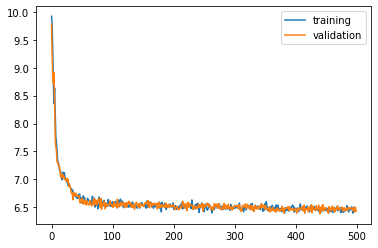

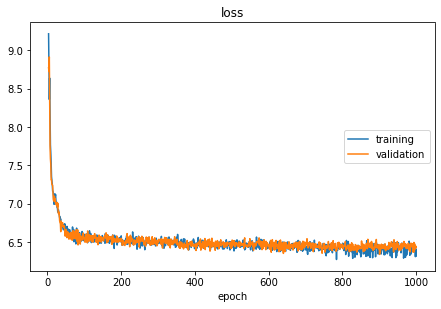

loss:
training   (min:    6.270, max:    9.923, cur:    6.316)
validation (min:    6.336, max:    9.786, cur:    6.430)


In [ ]:
import torch.optim as optim

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.2####
learning_rate = 0.0001#学習率を0.001とか大きめにとると（大きく無いと思うけど）途中でnanを吐き始める
decoder_learning_ratio = 5.0
n_iteration = 500000
print_every = 500
save_every = 1000
#cal_method='cos'
print('the number of data is',len(pairs))


# Initialize optimizers
print("Building optimizers ...")
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(
    decoder.parameters(), lr=learning_rate * decoder_learning_ratio
)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(
    model_name,
    voc,
    train_pairs,
    test_pairs,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    embedding,
    encoder_n_layers,
    decoder_n_layers,
    save_dir,
    n_iteration,
    batch_size,
    teacher_forcing_ratio,
    print_every,
    save_every,
    clip,
    corpus_name,
    loadFilename,
    #cal_method=cal_method
)

In [3]:
import torch.nn as nn

In [20]:
#評価するときだけ
def prepare_model(tf_ratio=0.2,
                  model_name='normal_model',
                  h_size=1024,
                  e_layer=4,
                  d_layer=4,
                  check_point=20000):
    teacher_forcing_ratio = tf_ratio####
    # Configure models
    #model_name = "cos_propose_model"
    model_name = model_name
    # attn_model = 'dot'
    # attn_model = 'general'
    attn_model = "concat"
    #hidden_size = 1024
    hidden_size = h_size
    encoder_n_layers = e_layer
    decoder_n_layers = d_layer
    dropout = 0.1
    batch_size = 512

    # Set checkpoint to load from; set to None if starting from scratch
    loadFilename = None
    checkpoint_iter = check_point
    loadFilename = os.path.join(save_dir, model_name, corpus_name,
                               '{}-{}_{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size, teacher_forcing_ratio),
                               '{}_checkpoint.tar'.format(checkpoint_iter))


    # Load model if a loadFilename is provided
    if loadFilename:
        print("load save file")
        # If loading on same machine the model was trained on
        checkpoint = torch.load(loadFilename)
        # If loading a model trained on GPU to CPU
        # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
        encoder_sd = checkpoint["en"]
        decoder_sd = checkpoint["de"]
        encoder_optimizer_sd = checkpoint["en_opt"]
        decoder_optimizer_sd = checkpoint["de_opt"]
        embedding_sd = checkpoint["embedding"]
        voc.__dict__ = checkpoint["voc_dict"]


    print("Building encoder and decoder ...")
    # Initialize word embeddings
    embedding = nn.Embedding(voc.num_words, hidden_size)
    if loadFilename:
        embedding.load_state_dict(embedding_sd)
    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = AttnDecoderRNN(
        attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout
    )
    if loadFilename:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print("Models built and ready to go!")

In [25]:
#訓練するときだけ

# Configure models
model_name = "normal_model"
# attn_model = 'dot'
# attn_model = 'general'
attn_model = "concat"
hidden_size = 1024
encoder_n_layers = 4
decoder_n_layers = 4
dropout = 0.1
batch_size = 512

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 3000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size, teacher_forcing_ratio),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    print("load save file")
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint["en"]
    decoder_sd = checkpoint["de"]
    encoder_optimizer_sd = checkpoint["en_opt"]
    decoder_optimizer_sd = checkpoint["de_opt"]
    embedding_sd = checkpoint["embedding"]
    voc.__dict__ = checkpoint["voc_dict"]


print("Building encoder and decoder ...")
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = AttnDecoderRNN(
    attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout
)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print("Models built and ready to go!")

Building encoder and decoder ...
self.vのパラメタNaNの数 tensor(0)
Models built and ready to go!


In [ ]:
import random

In [1]:
a = [random.choice(pairs) for _ in range(5)]
input_variable, lengths, target_variable, mask, max_target_len = batch2TrainData(voc,a)
# batch2TrainData(voc,a)
embedding = nn.Embedding(voc.num_words, 3)
encoder = EncoderRNN(3, embedding, 2, 0)
# decoder = AttnDecoderRNN(
#     "general", embedding, 3, voc.num_words, 2, 0
# )
print(input_variable.size())
encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
print(encoder_outputs.size(),encoder_hidden.size())
#     # Create initial decoder input (start with SOS tokens for each sentence)
# decoder_input = torch.LongTensor([[SOS_token for i in range(5)]])
# decoder_input = decoder_input

# # Set initial decoder hidden state to the encoder's final hidden state
# decoder_hidden = encoder_hidden[: 2]
# decoder_outputs, decoder_hidden = decoder(
#     decoder_input, decoder_hidden, encoder_outputs
# )
# print(decoder_outputs.size())
# embedding = nn.Embedding(voc.num_words, 3)
# embedded = embedding(input_variable)
# packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths)
# gru = nn.GRU(3,3,4,dropout=0,bidirectional=True)
# outputs, hidden = gru(packed, None)
# print(outputs[0].size(),"hidden",hidden.size())
# outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
# print(outputs.size(),"hidden",hidden.size())
# outputs = outputs[:, :, :3] + outputs[:, :, 3:]
# print(outputs.size())
# decoder_input = torch.LongTensor([[SOS_token for i in range(5)]])
# decoder_hidden = hidden[:4]
# print('decoder_hidden',decoder_hidden.size())
# embedding = nn.Embedding(voc.num_words, 3)
# embedded = embedding(decoder_input)
# grud = nn.GRU(3,3,4,dropout=0)
# print(embedded.size(),decoder_hidden.size())
# grud(embedded,decoder_hidden)

NameError: name 'random' is not defined

In [ ]:
class BeamSearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, beam_width, n_best):
        super(BeamSearchDecoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.beam_width = beam_width
        self.n_best = n_best
        
    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[: decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token

In [26]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[: decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores
    
    
import sentencepiece as spm
segmentation_model_position = './data'
segmentation_model_name = 'train_model8000.model'

spp = spm.SentencePieceProcessor()
spp.Load(os.path.join(segmentation_model_position, segmentation_model_name))
def normalizeString(input_sentence):
    splitSentence = ' '.join(spp.EncodeAsPieces(input_sentence))
    return splitSentence

In [27]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ""
    while 1:
        try:
            # Get input sentence
            input_sentence = input("> ")
            # Check if it is quit case
            if input_sentence == "q" or input_sentence == "quit":
                break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            print('入力を分割すると',input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [
                x for x in output_words if not (x == "EOS" or x == "PAD")
            ]
            print("Bot:", " ".join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [28]:
encoder.eval()

decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

>  帰りたい


入力を分割すると ▁ 帰り たい
Bot: ぼ ぼ ぼ ぼ ぼ しく しく あげよう あげよう の為に の為に 酩酊 酩酊 したことない 曙


>  酒のみすぎたんだけど


入力を分割すると ▁ 酒 のみ すぎた んだけど
Bot: 袁 嫌な 嫌な 嫌な 嫌な 嫌な でございます でございます 嫌な 嫌な 変えて 変えて でございます でございます 変えて


>  q


In [76]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
def cal_bleu_score(pairs, encoder, decoder):
    encoder.eval()
    decoder.eval()

    searcher = GreedySearchDecoder(encoder, decoder)
    score = 0
    for pair in tqdm(pairs):
        input_sentence = normalizeString(pair[0])
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
        candidate = [x for x in output_words if not (x == "EOS" or x == "PAD")]
        reference = [pair[1].split(' ')]
        score += sentence_bleu(reference, candidate)
        #print(candidate,'\n',reference,'\n',sentence_bleu(reference, candidate))
    return score/len(pairs)

In [77]:
prepare_model(model_name='cb_model', check_point=20000)
cal_bleu_score(pairs, encoder, decoder)

load save file
Building encoder and decoder ...


  0%|          | 11/53165 [00:00<08:26, 104.95it/s]

self.vのパラメタNaNの数 tensor(0)
Models built and ready to go!


100%|██████████| 53165/53165 [07:53<00:00, 112.32it/s]


0.4206171036107889